# Fitting Latest Data and Providing Future Estimates

The following consists of a fit to Danish Covid-19 test data, with the aim of determining most precisely the picture for the coming months time.

The fit determins the parameters of the current situation, that is the number of daily positives $P_i$, which is scaled in relation to the number of daily tests $T_i$ as $(T_i/\bar{T})^{-\gamma}$ where $\gamma \sim 0.5-0.7$ (determined by MeasuringTestScalingExponent.ipynb), as the number of positives does not grow linearly with number of tests. From this fit one can also extract the contact number and possibly changes in it, when restrictions change. Based on the lockdown from the beginning of the year until 8th of February, the fit assumes an unchanged contact number for this period.

The fit model to the Scaled Positives is: $SP(t) = SP(t_0) ~ R^{(t-t_0)/t_G}$, where $t_G = 4.7$ days.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
import scipy 
import scipy.stats
from scipy import stats
import iminuit
from iminuit import Minuit

mpl.rcParams['font.size'] = 18      # Set the general plotting font size
plt.rc("font", family="serif")
#plt.rc("text", usetex=True)

save_plots = True
fit_to_latest = True

***

# Read the data:

In [2]:
# data_posi = pd.read_csv("Data-Epidemiologiske-Rapport-19032021-j3k4/Municipality_cases_time_series.csv", sep=';', thousands='.', index_col=0)
# data_test = pd.read_csv("Data-Epidemiologiske-Rapport-19032021-j3k4/Municipality_tested_persons_time_series.csv", sep=';', thousands='.', index_col=0)

data_posi = pd.read_csv("Data-Epidemiologiske-Rapport-24032021-6m2k/Municipality_cases_time_series.csv", sep=';', thousands='.', index_col=0)
data_test = pd.read_csv("Data-Epidemiologiske-Rapport-24032021-6m2k/Municipality_tested_persons_time_series.csv", sep=';', thousands='.', index_col=0)

# Print how much data is included:
date_start = "2021-01-01"            # This is thus day 0
if fit_to_latest :
    date_end = data_test.index[-3]   # Omitting the very latest data point (with ~0 statistics)
else :
    date_end = "2021-03-06"          # Value in latest report files
print("  Data used: ", date_start, "-", date_end)    

# Number of Positives (P) and Tests (T) for all of Denmark ("all")
P_all = data_posi.loc[date_start:date_end].sum(axis=1)
eP_all = np.sqrt(P_all)
T_all = data_test.loc[date_start:date_end].sum(axis=1)
eT_all = np.sqrt(T_all)

  Data used:  2021-01-01 - 2021-03-22


---

# Scale and correct the data:

### Define the constants to be used:

The generation time is fixed (from other sources), while the power $\gamma$, the weekly correction factor, and the systematic uncertainties are obtained from the script "Measuring Test Scaling Exponent".

* The average time between generations has been estimated to be $t_G = 4.7$ days.
* The power $\gamma$ to be used in the scaling with number of tested is chosen to be $\gamma = -0.6$.
* The (multiplicative) weekly fluctuations are a further correction.
* The (multiplicative) systematic uncertainty to apply in order to get a decent Chi2 is so far zero. 

In [3]:
# Average time between generations (in days):
tG = 4.7

# Number of positive tests and uncertainty, assuming fixed number of daily tests and power law correction:
Power = -0.50

# Correct for effects of weekdays, corrects from 2nd January forward:
frac = [0.068, 0.096, 0.036, -0.075, -0.115, 0.012, 0.003]    # Based on 1st of January to 15th of February
frac_fra_lørdag = np.roll(frac, -4)    # This corresponds to 1st of January being a Friday (=4)

# To account for larger uncertainties in positives in data than simply the statistical:
SystError = 0.0                      # Should be included at some point
SystErrorScale = 1.0                 # 1.0 (i.e. doubling of error) works OK!

# Fitting function for fraction B117:
t0_B117fit  = 35.0        # t0 is 2021-02-04
frac_t0     = 0.255       # +- 0.008   
tau_B117    = 12.19       # +- 0.40
factor_B117 = np.e**(tG/tau_B117)     # = 1.47. Thus B117 is a factor 1.47 more infectious

def func_fB117(t, frac_t0, tau) :
    return frac_t0*np.exp((t-t0_B117fit)/tau) / ((1-frac_t0) + frac_t0*np.exp((t-t0_B117fit)/tau))

### Calculated the scaled and corrected number of positives:

In [4]:
# These are also the days where corrections are applied:
Plot_StartDay = 0         # 1st of January 2021
Plot_EndDay   = len(P_all)

# Calculate the Scaled Positives (SP):
nAveDailyTests_all = T_all.mean()
print("Average number of PCR tests: ", nAveDailyTests_all)
fPos_all = P_all / T_all
efPos_all = np.sqrt(fPos_all*(1.0-fPos_all)/T_all + SystError**2)
eP_all  = np.sqrt(T_all*fPos_all*(1-fPos_all)) * (1.0 + SystErrorScale)
SP_all  = P_all  * (T_all / nAveDailyTests_all)**Power
eSP_all = eP_all * (T_all / nAveDailyTests_all)**Power

# Calculate the Scaled CORRECTED Positives (SCP), i.e. apply correction for weekdays:
SCP_all = np.zeros_like(SP_all)
eSCP_all = np.zeros_like(eSP_all)
for i,x,dx in zip(np.arange(Plot_StartDay,Plot_StartDay+len(SP_all[Plot_StartDay:Plot_EndDay])),
                  SP_all[Plot_StartDay:Plot_EndDay], eSP_all[Plot_StartDay:Plot_EndDay]) :
    factor = 1.0               # Just for testing, if the "strength" of the effect is reasonable
    SCP_all[i] = x*(1 - factor * frac_fra_lørdag[i%7])
    eSCP_all[i] = dx*(1 - factor * frac_fra_lørdag[i%7])

# Print the data used for fits:
print(" Date      Ntest      Nposi (P)    SP         SCP")
for i in range(len(T_all)) :
    # date_of_month = td.
    print(f"{i+1:4d}   {T_all[i]:10d}  {P_all[i]:8d}    {SP_all[i]:8.0f}   {SCP_all[i]:8.0f}")

Average number of PCR tests:  142826.62962962964
 Date      Ntest      Nposi (P)    SP         SCP
   1        30658      1183        2553       2847
   2        71118      2028        2874       2839
   3        63487      1654        2481       2473
   4       103263      2460        2893       2696
   5       102211      1913        2261       2044
   6        93939      1646        2030       1957
   7        83726      1576        2058       2213
   8        73919      1423        1978       2205
   9        51396      1190        1984       1960
  10        47101       987        1719       1714
  11        79208      1337        1795       1673
  12        83218      1247        1634       1477
  13        76032      1103        1512       1457
  14       103702       998        1171       1259
  15        97643       846        1023       1141
  16        75591       718         987        975
  17        73625       668         930        928
  18       107816       913       

---

# Fit the data:

### Define plotting and fitting ranges:

Data before 1st of September 2020 seems irrelevant, as the test system and volume was very different, and since the behaviour and test patterns of the population may have changed since then. The typical starting date for plotting is **1st of January 2021**.

In [5]:
Fit_StartDay   = 3         # 4th of January 2021
Fit_EndDay     = len(P_all) - 0                            # Omitting the last day - changable parameter
Fit_EndDayJan  = 31                                        # Alternative end day (for testing)
day1jan        = np.arange(Plot_StartDay, Plot_EndDay)
day1jan_fit    = np.arange(Fit_StartDay,  Fit_EndDay)
day1jan_fitJan = np.arange(Fit_StartDay,  Fit_EndDayJan)   # Fitting only January!
day_extrapol   = np.arange(Fit_EndDay+1,  Fit_EndDay+28)   # We extrapole 21 days into the future (for now)
day_all        = np.arange(Plot_StartDay, Fit_EndDay+28)   # Entire periodd

## Fit the PCR test data (assuming no B117):

In [6]:
# Exponential function with base Rt:
def func_Expo(x, N0, Rt, t0, tG) :
    # NOTE: tG = time_generation, i.e. average time between generations.
    return N0 * Rt**((x-t0)/tG)

# ChiSquare fit model:
def chi2_calc0(N0, Rt, t0, tG) :
    y_fit = func_Expo(day1jan_fitJan, N0, Rt, t0, tG)
    chi2 = np.sum(((SCP_all[Fit_StartDay:Fit_EndDayJan] - y_fit) / eSCP_all[Fit_StartDay:Fit_EndDayJan])**2)
    return chi2

minuit0 = Minuit(chi2_calc0, N0=1000.0, Rt=0.8, t0=1.0, fix_t0=True, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit0.migrad();                                                  
    
# Here we extract the fitting parameters and their errors
N0_fit = minuit0.values['N0'];       sigma_N0_fit = minuit0.errors['N0']
Rt_fit = minuit0.values['Rt'];       sigma_Rt_fit = minuit0.errors['Rt']
t0_fit = minuit0.values['t0'];       sigma_t0_fit = minuit0.errors['t0']
tG_fit = minuit0.values['tG'];       sigma_tG_fit = minuit0.errors['tG']
print(f"  Rt fit = {minuit0.values['Rt']:5.3f} +- {minuit0.errors['Rt']:5.3f}")

# Calcuate fit quality:
Chi2_fit = minuit0.fval       # The Chi2 value
Npoints = len(day1jan_fitJan) # Number of points fitted
Nvar = 2                      # Number of variables (tG is fixed!)
Ndof_fit = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit:5.1f}, Ndof={Ndof_fit:2d}) = {Prob_fit:5.3f}")

------------------------------------------------------------------
| FCN = 58.44                   |      Ncalls=72 (72 total)      |
| EDM = 1.3e-05 (Goal: 0.0002)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
  Rt fit = 0.747 +- 0.006
  Prob(Chi2= 58.4, Ndof=26) = 0.000


## Fit the PCR test data **including** B117 component:

With two exponentials, the fit expands in complexity. However, the different $R$ values for DK and UK versions are coupled, based on the B117 fit. Furthermore, the normalisations are also related, as we know the fraction of B117, again from the B117 fit.

This is included by multiplying the $R$ value (which is for the DK version) by the known infection factor to B117, and by fixing the ratio of the DK and UK normalisations at $t_0$. We choose $t_0$ to be the 4th of February (day 0 in B117 fit, day 35 here), and scale between DK and UK versions from that date.

In [7]:
# Exponential function with base Rt:
def func_DoubleExpo(x, N0, Rt, t0, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    return N0 * ((1.0-FracB117_at_t0) * Rt**((x-t0)/tG) + FracB117_at_t0 * (Rt * factor_B117)**((x-t0)/tG))

# ChiSquare fit model:
def chi2_calc(N0, Rt, t0, tG) :
    y_fit = func_DoubleExpo(day1jan_fitJan, N0, Rt, t0, tG)
    chi2 = np.sum(((SCP_all[Fit_StartDay:Fit_EndDayJan] - y_fit) / eSCP_all[Fit_StartDay:Fit_EndDayJan])**2)
    return chi2

minuit2 = Minuit(chi2_calc, N0=400.0, Rt=0.7, t0=t0_B117fit, fix_t0=True, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit2.migrad();                                                  
    
# Here we extract the fitting parameters and their errors
N0_fit2 = minuit2.values['N0'];       sigma_N0_fit2 = minuit2.errors['N0']
Rt_fit2 = minuit2.values['Rt'];       sigma_Rt_fit2 = minuit2.errors['Rt']
t0_fit2 = minuit2.values['t0'];       sigma_t0_fit2 = minuit2.errors['t0']
#tG_fit2 = minuit2.values['tG'];       sigma_tG_fit2 = minuit2.errors['tG']
print("  N0 fit = ", N0_fit2, "+-", sigma_N0_fit2)
print("  Rt fit = ", Rt_fit2, "+-", sigma_Rt_fit2)
#print("  t0 fit = ", t0_fit2, "+-", sigma_t0_fit2)

# Calcuate fit quality:
Chi2_fit2 = minuit2.fval       # The Chi2 value
Npoints = len(day1jan_fitJan)     # Number of points fitted
Nvar = 2                       # Number of variables (t0 and tG are fixed!)
Ndof_fit2 = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit2 = stats.chi2.sf(Chi2_fit2, Ndof_fit2)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit2:5.1f}, Ndof={Ndof_fit2:2d}) = {Prob_fit2:5.3f}")

------------------------------------------------------------------
| FCN = 56.56                   |      Ncalls=45 (45 total)      |
| EDM = 1.27e-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
  N0 fit =  372.25808811306666 +- 13.80274361180364
  Rt fit =  0.7278509209940688 +- 0.005395909228871195
  Prob(Chi2= 56.6, Ndof=26) = 0.000


## Fit the PCR test data with a change in R:

Given a change of $R$ at $t_0$, the fit expands to have at least two $R$ values (before and after $t_0$) and possibly also $t_0$ in itself, if this is to be a floating parameter (as now).

In [8]:
# Exponential function with base Rb (= before t0) and Ra (= after t0):
# Note that the B117 fraction calculation is done at a FIXED time, while t0 can vary at will.
def func_DoubleExpoStep(x, N0, Rb, Ra, t0, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    if (x < t0) :
        return N0 * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG) + FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG))
    else :
        return N0 * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG) + FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG))

func_DoubleExpoStep_vec = np.vectorize(func_DoubleExpoStep)

# The DK component of the above function:
def func_StepRDK(x, N0, Rb, Ra, t0, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    if (x < t0) :
        return N0 * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG))
    else :
        return N0 * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG))
func_StepRDK_vec = np.vectorize(func_StepRDK)

# The UK B117 component of the above function:
def func_StepRB117(x, N0, Rb, Ra, t0, tG):
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    if (x < t0) :
        return N0 * FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG)
    else :
        return N0 * FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG)
func_StepRB117_vec = np.vectorize(func_StepRB117)

# ChiSquare fit model:
def chi2_calcStep(N0, Rb, Ra, t0, tG) :
    y_fit = func_DoubleExpoStep_vec(day1jan_fit, N0, Rb, Ra, t0, tG)
    chi2 = np.sum(((SCP_all[Fit_StartDay:Fit_EndDay] - y_fit) / eSCP_all[Fit_StartDay:Fit_EndDay])**2)
    return chi2

minuit3 = Minuit(chi2_calcStep, N0=400.0, Rb=0.7, Ra=0.7, t0=30.0, fix_t0=False, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit3.migrad();                                                  

# Here we extract the fitting parameters and their errors
N0_fit3 = minuit3.values['N0'];       sigma_N0_fit3 = minuit3.errors['N0']
Rb_fit3 = minuit3.values['Rb'];       sigma_Rb_fit3 = minuit3.errors['Rb']
Ra_fit3 = minuit3.values['Ra'];       sigma_Ra_fit3 = minuit3.errors['Ra']
t0_fit3 = minuit3.values['t0'];       sigma_t0_fit3 = minuit3.errors['t0']
print("  N0 fit = ", N0_fit3, "+-", sigma_N0_fit3)
print("  Rb fit = ", Rb_fit3, "+-", sigma_Rb_fit3)
print("  Ra fit = ", Ra_fit3, "+-", sigma_Ra_fit3)
print("  t0 fit = ", t0_fit3, "+-", sigma_t0_fit3)

# Calcuate fit quality:
Chi2_fit2 = minuit3.fval       # The Chi2 value
Npoints = len(day1jan_fit)     # Number of points fitted
Nvar = 3                       # Number of variables (tG is fixed!)
Ndof_fit2 = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit2 = stats.chi2.sf(Chi2_fit2, Ndof_fit2)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit2:5.1f}, Ndof={Ndof_fit2:2d}) = {Prob_fit2:5.3f}")

------------------------------------------------------------------
| FCN = 142.7                   |     Ncalls=254 (254 total)     |
| EDM = 0.000122 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
  N0 fit =  929.3876134590746 +- 47.257798679723976
  Rb fit =  0.6675798827318667 +- 0.010207794670484051
  Ra fit =  0.726755806957376 +- 0.0042831729535569105
  t0 fit =  17.059842463903873 +- 

## Fit the PCR test data with a change in R and effect of winter vacation:

In addition to the change in $R$, this fit also includes a (sigmoid) change in number of positives, as a result of the winter vacation (week 7 and 8).

In [9]:
# Exponential function with base Rb (= before t0) and Ra (= after t0):
#   Note that the B117 fraction calculation is done at a FIXED time, while t0 can vary at will.
#   The Winter vacation factor (factorW) models the rise with a sigmoid function.
def func_DoubleExpoStepW(x, N0, Rb, Ra, t0, fW, tW, sW, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    FactorW = 1.0 + fW/(1.0 + np.exp(-(x-tW)/sW))
    if (x < t0) :
        return N0 * FactorW * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG) + FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG))
    else :
        return N0 * FactorW * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG) + FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG))

func_DoubleExpoStepW_vec = np.vectorize(func_DoubleExpoStepW)

# Same function as above, just also including Easter vacation (for prediction):
def func_DoubleExpoStepWE(x, N0, Rb, Ra, t0, fW, tW, sW, fE, tE, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    FactorW = 1.0 + fW/(1.0 + np.exp(-(x-tW)/sW))
    FactorE = 1.0 + fE/(1.0 + np.exp(-(x-tE)/sW))
    if (x < t0) :
        return N0 * FactorW * FactorE * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG) + FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG))
    else :
        return N0 * FactorW * FactorE * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG) + FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG))

func_DoubleExpoStepWE_vec = np.vectorize(func_DoubleExpoStepWE)


# The DK component of the above function:
def func_StepRDK(x, N0, Rb, Ra, t0, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    if (x < t0) :
        return N0 * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG))
    else :
        return N0 * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG))
func_StepRDK_vec = np.vectorize(func_StepRDK)

# The UK B117 component of the above function:
def func_StepRB117(x, N0, Rb, Ra, t0, tG):
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    if (x < t0) :
        return N0 * FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG)
    else :
        return N0 * FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG)
func_StepRB117_vec = np.vectorize(func_StepRB117)

# ChiSquare fit model:
def chi2_calcStepW(N0, Rb, Ra, t0, fW, tW, sW, tG) :
    y_fit = func_DoubleExpoStepW_vec(day1jan_fit, N0, Rb, Ra, t0, fW, tW, sW, tG)
    chi2 = np.sum(((SCP_all[Fit_StartDay:Fit_EndDay] - y_fit) / eSCP_all[Fit_StartDay:Fit_EndDay])**2)
    return chi2

minuit3w = Minuit(chi2_calcStepW, N0=400.0, Rb=0.7, Ra=0.7, t0=28.0, fix_t0=False, fW=0.5, tW=46.0, sW=0.5, fix_sW=True, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit3w.migrad();

# Here we extract the fitting parameters and their errors
N0_fit3w = minuit3w.values['N0'];       sigma_N0_fit3w = minuit3w.errors['N0']
Rb_fit3w = minuit3w.values['Rb'];       sigma_Rb_fit3w = minuit3w.errors['Rb']
Ra_fit3w = minuit3w.values['Ra'];       sigma_Ra_fit3w = minuit3w.errors['Ra']
t0_fit3w = minuit3w.values['t0'];       sigma_t0_fit3w = minuit3w.errors['t0']
fW_fit3w = minuit3w.values['fW'];       sigma_fW_fit3w = minuit3w.errors['fW']
tW_fit3w = minuit3w.values['tW'];       sigma_tW_fit3w = minuit3w.errors['tW']
sW_fit3w = minuit3w.values['sW'];       sigma_sW_fit3w = minuit3w.errors['sW']
print("  N0 fit = ", N0_fit3w, "+-", sigma_N0_fit3w)
print("  Rb fit = ", Rb_fit3w, "+-", sigma_Rb_fit3w)
print("  Ra fit = ", Ra_fit3w, "+-", sigma_Ra_fit3w)
print("  t0 fit = ", t0_fit3w, "+-", sigma_t0_fit3w)
print("  fW fit = ", fW_fit3w, "+-", sigma_fW_fit3w)
print("  tW fit = ", tW_fit3w, "+-", sigma_tW_fit3w)
# print("  sW fit = ", sW_fit3w, "+-", sigma_sW_fit3w)

# Calcuate fit quality:
Chi2_fit2 = minuit3w.fval       # The Chi2 value
Nvar = 5                       # Number of variables (tG is fixed!)
Ndof_fit2 = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit2 = stats.chi2.sf(Chi2_fit2, Ndof_fit2)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit2:5.1f}, Ndof={Ndof_fit2:2d}) = {Prob_fit2:5.3f}")

------------------------------------------------------------------
| FCN = 82.18                   |     Ncalls=498 (498 total)     |
| EDM = 1.64e-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
  N0 fit =  954.0502916384587 +- 81.04755539042287
  Rb fit =  0.6813794005954559 +- 0.011929951660648832
  Ra fit =  0.7017525681845332 +- 0.006232664251652689
  t0 fit =  17.35911302580976 +- 1.

## Fit the PCR test data with a TWO changes in R:

Given a change of $R$ at $t_0$, the fit is now expanded to have **TWO** changes in $R$ values: From Rb to Ra at t0, and from Ra to Rc at t1. This is used to test if the opening of schools (Monday the 8th of February) had any effect, and therefore t1 is fixed to a generation time after this opening (= day 42).

In [10]:
# Exponential function with base Rb (= before t0), Ra (= after t0), and Rc (after t1):
def func_DoubleExpoStep2(x, N0, Rb, Ra, Rc, t0, t1, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    if (x < t0) :
        return N0 * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG) + FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG))
    elif (x < t1) :
        return N0 * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG) + FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG))
    else :
        N1 = N0 * ((1.0-FracB117_at_t0) * Ra**((t1-t0)/tG) + FracB117_at_t0 * (Ra * factor_B117)**((t1-t0)/tG))
        return N1 * ((1.0-FracB117_at_t0) * Rc**((x-t1)/tG) + FracB117_at_t0 * (Rc * factor_B117)**((x-t1)/tG))

func_DoubleExpoStep2_vec = np.vectorize(func_DoubleExpoStep2)

# ChiSquare fit model:
def chi2_calcStep2(N0, Rb, Ra, Rc, t0, t1, tG) :
    y_fit = func_DoubleExpoStep2_vec(day1jan_fit, N0, Rb, Ra, Rc, t0, t1, tG)
    chi2 = np.sum(((SCP_all[Fit_StartDay:Fit_EndDay] - y_fit) / eSCP_all[Fit_StartDay:Fit_EndDay])**2)
    return chi2

# The t0 is now just set to the end of the B117-fit... it should of course not be... To Be Changed/Updated!
minuit4 = Minuit(chi2_calcStep2, N0=400.0, Rb=0.7, Ra=0.8, Rc=0.9, t0=37.0, fix_t0=False, t1=42.0, fix_t1=True, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit4.migrad();                                                  

# Here we extract the fitting parameters and their errors
N0_fit4 = minuit4.values['N0'];       sigma_N0_fit4 = minuit4.errors['N0']
Rb_fit4 = minuit4.values['Rb'];       sigma_Rb_fit4 = minuit4.errors['Rb']
Ra_fit4 = minuit4.values['Ra'];       sigma_Ra_fit4 = minuit4.errors['Ra']
Rc_fit4 = minuit4.values['Rc'];       sigma_Rc_fit4 = minuit4.errors['Rc']
t0_fit4 = minuit4.values['t0'];       sigma_t0_fit4 = minuit4.errors['t0']
t1_fit4 = minuit4.values['t1'];       sigma_t1_fit4 = minuit4.errors['t1']
print("  N0 fit = ", N0_fit4, "+-", sigma_N0_fit4)
print("  Rb fit = ", Rb_fit4, "+-", sigma_Rb_fit4)
print("  Ra fit = ", Ra_fit4, "+-", sigma_Ra_fit4)
print("  Rc fit = ", Rc_fit4, "+-", sigma_Rc_fit4)
print("  t0 fit = ", t0_fit4, "+-", sigma_t0_fit4)
print("  t1 fit = ", t1_fit4, "+-", sigma_t1_fit4)

# Calcuate fit quality:
Chi2_fit2 = minuit4.fval       # The Chi2 value
Nvar = 3                       # Number of variables (tG is fixed!)
Ndof_fit2 = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit2 = stats.chi2.sf(Chi2_fit2, Ndof_fit2)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit2:5.1f}, Ndof={Ndof_fit2:2d}) = {Prob_fit2:5.3f}")

------------------------------------------------------------------
| FCN = 178.6                   |     Ncalls=220 (220 total)     |
| EDM = 5.31e-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
  N0 fit =  443.4836363998418 +- 23.06118175118142
  Rb fit =  0.7255909402367194 +- 0.006050302734899334
  Ra fit =  0.9575681266377801 +- 0.040085404708838715
  Rc fit =  0.8100685681075109 +- 0

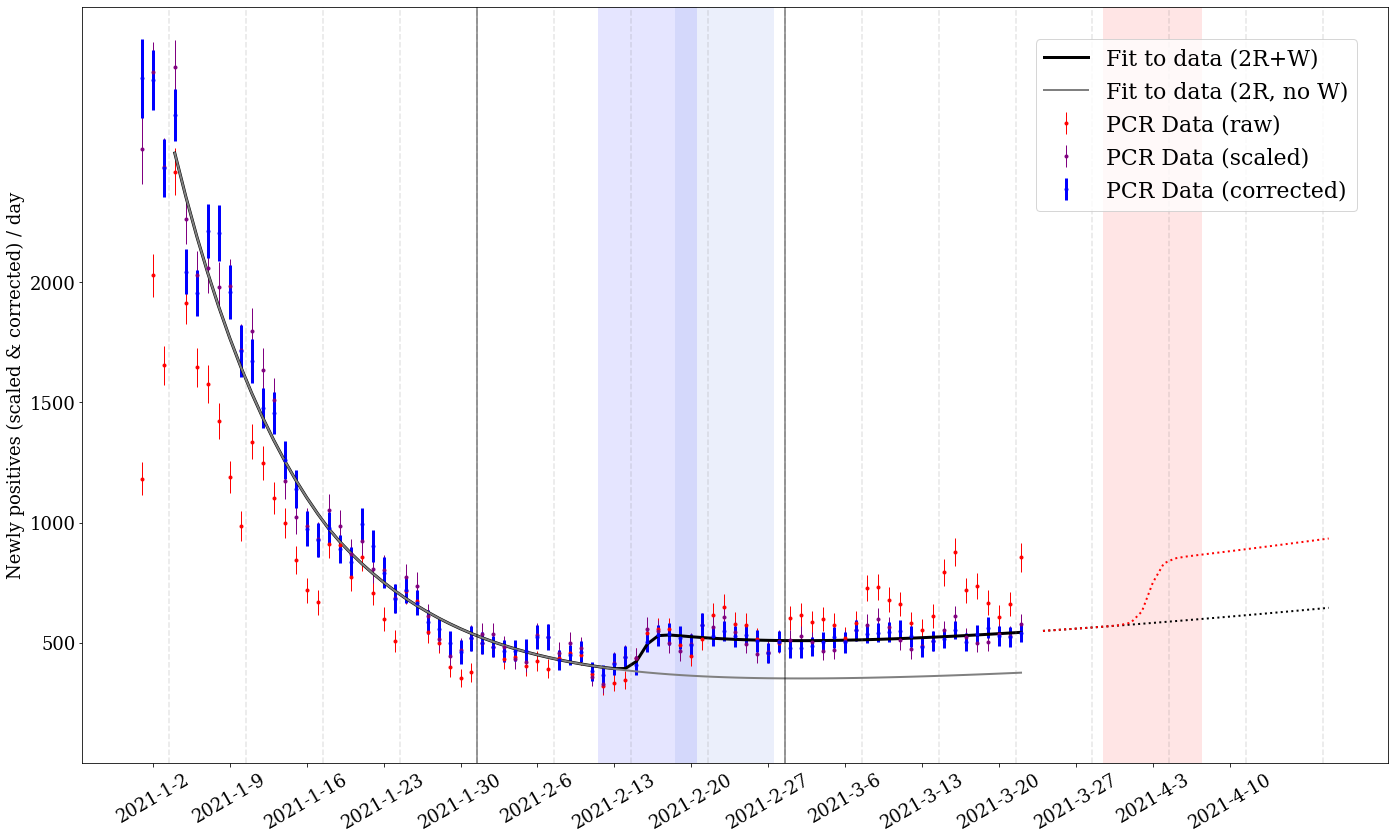

In [11]:
# Put dates on the x-axis:
now = dt.datetime.now()         # Changed to the last date of data?
then = now + dt.timedelta(days=-(Plot_EndDay-Plot_StartDay))
dato_start = "2021-01-01"

fig, ax = plt.subplots(figsize=(20, 12))
ax.set(xlabel="", ylabel="Newly positives (scaled & corrected) / day", title="")
ax.errorbar(day1jan, P_all[Plot_StartDay:Plot_EndDay], yerr=eP_all[Plot_StartDay:Plot_EndDay], fmt='.', linewidth=1, label='PCR Data (raw)', color='red')
ax.errorbar(day1jan, SP_all[Plot_StartDay:Plot_EndDay], yerr=eSP_all[Plot_StartDay:Plot_EndDay], fmt='.', linewidth=1, label='PCR Data (scaled)', color='purple')
ax.errorbar(day1jan, SCP_all[Plot_StartDay:Plot_EndDay], yerr=eSCP_all[Plot_StartDay:Plot_EndDay], fmt='.', linewidth=3, label='PCR Data (corrected)', color='blue')

# Plot the fit model on top of data:
#ax.plot(day1jan_fitJan, func_Expo(day1jan_fitJan, N0_fit, Rt_fit, t0_fit, tG_fit), 'green', linewidth=1.0, label='Exp. fit (no B117)')
#ax.plot(day1jan_fitJan, func_DoubleExpo(day1jan_fitJan, N0_fit2, Rt_fit2, t0_fit2, tG), 'blue',  linewidth=1.0, label='Fit to data')

# ax.plot(day1jan_fit,    func_DoubleExpoStep_vec(day1jan_fit,  N0_fit3, Rb_fit3, Ra_fit3, t0_fit3, tG), 'red', linewidth=2.0, label='Fit to data (2R)')
# ax.plot(day_extrapol,   func_DoubleExpoStep_vec(day_extrapol, N0_fit3, Rb_fit3, Ra_fit3, t0_fit3, tG), 'red', linewidth=1.0, linestyle="dotted")
#ax.plot(day1jan_fit,    func_DoubleExpoStep2_vec(day1jan_fit, N0_fit4, Rb_fit4, Ra_fit4, Rc_fit4, t0_fit4, t1_fit4, tG), 'green', linewidth=1.0, label='Fit to data (3R)')
ax.plot(day1jan_fit,    func_DoubleExpoStepW_vec(day1jan_fit,  N0_fit3w, Rb_fit3w, Ra_fit3w, t0_fit3w, fW_fit3w, tW_fit3w, sW_fit3w, tG), 'black', linewidth=3.0, label='Fit to data (2R+W)')
ax.plot(day_extrapol,   func_DoubleExpoStepW_vec(day_extrapol, N0_fit3w, Rb_fit3w, Ra_fit3w, t0_fit3w, fW_fit3w, tW_fit3w, sW_fit3w, tG), 'black', linewidth=2.0, linestyle="dotted")

# Plot with Easter vacation in prediction (assuming same size)
dayEaster = 31+28+28
ax.plot(day_extrapol,   func_DoubleExpoStepWE_vec(day_extrapol,N0_fit3w, Rb_fit3w, Ra_fit3w, t0_fit3w, fW_fit3w, tW_fit3w, sW_fit3w, fW_fit3w, dayEaster+tG, tG), 'red', linewidth=2.0, linestyle="dotted")

# Without Winter vacation:
ax.plot(day1jan_fit,    func_DoubleExpoStepW_vec(day1jan_fit,  N0_fit3w, Rb_fit3w, Ra_fit3w, t0_fit3w, 0.0, tW_fit3w, sW_fit3w, tG), 'grey', linewidth=2.0, label='Fit to data (2R, no W)')
# ax.plot(day_extrapol,   func_DoubleExpoStepW_vec(day_extrapol, N0_fit3w, Rb_fit3w, Ra_fit3w, t0_fit3w, 0.0, tW_fit3w, sW_fit3w, tG), 'grey', linewidth=1.0, linestyle="dotted")

# Dividing into DK and UK/B117 versions:
# ax.plot(day1jan_fit,    func_StepRDK_vec(day1jan_fit,   N0_fit3, Rb_fit3, Ra_fit3, t0_fit3, tG), 'green', linewidth=1.0, label='Only DK version')
# ax.plot(day1jan_fit,    func_StepRB117_vec(day1jan_fit, N0_fit3, Rb_fit3, Ra_fit3, t0_fit3, tG), 'blue', linewidth=1.0, label='Only B117 version')

# Plot an "envelope" of possible predictions:
#ax.plot(day_extrapol, func_DoubleExpoStep_vec(day_extrapol, N0_fit3, Rb_fit3, Ra_fit3+2*sigma_Ra_fit3, t0_fit3, tG), 'red', linewidth=1.0, linestyle="dotted")
#ax.plot(day_extrapol, func_DoubleExpoStep_vec(day_extrapol, N0_fit3, Rb_fit3, Ra_fit3-2*sigma_Ra_fit3, t0_fit3, tG), 'red', linewidth=1.0, linestyle="dotted")
#ax.fill_between(day_extrapol, func_DoubleExpoStep_vec(day_extrapol, N0_fit3, Rb_fit3, Ra_fit3+2*sigma_Ra_fit3, t0_fit3, tG), func_DoubleExpoStep_vec(day_extrapol, N0_fit3, Rb_fit3, Ra_fit3-2*sigma_Ra_fit3, t0_fit3, tG), color='red', alpha=0.3, label='Extrapolation')

# Put nice labels on the original axis:
plt.xticks(ticks=np.arange(1,len(P_all[dato_start:]),7), labels=np.array(P_all[dato_start::7].index), rotation=30)
for x in np.arange(2.5, max(day_extrapol), 7): 
    plt.axvline( x, ls='--', color='grey', alpha=0.2)

times = []; N_weeks = int(max(day_extrapol)/7)
for i in range(N_weeks):
    times.append(then + dt.timedelta(days=7*i))
    
plt.xticks(ticks=[7*i+1 for i in range(N_weeks)], 
           labels=[str(time.year)+'-'+str(time.month)+'-'+str(time.day) for time in times])

# Plot monthly lines on first date:
d_now = dt.date(year=int(date_start[:4]), month = int(date_start[5:7]), day = int(date_start[8:] ))
for i in range(len(data_posi.loc[date_start:date_end].sum(axis=1))):
    d_now = d_now + dt.timedelta(days=1)
    if d_now.day == 1:
        plt.axvline( i+0.5, ls='-', color='k', alpha=0.5)

# Show the Winter vacation
# ax.axvspan(41.5, 50.5, facecolor='r', alpha=0.1, label="Winter vacation (W7)")
# ax.axvspan(48.5, 57.5, facecolor='b', alpha=0.1, label="Winter vacation (W8)")
ax.axvspan(41.5, 50.5, facecolor='b', alpha=0.1)
ax.axvspan(48.5, 57.5, facecolor='royalblue', alpha=0.1)
ax.axvspan(dayEaster+0.5, dayEaster+9.5, facecolor='r', alpha=0.1)

# Plot the fraction of B117 on secondary y-axis (to the right):
#ax2 = ax.twinx()
#ax2.plot(day_all, func_logistic(day_all-33, *[frac_t0_fit, tau_fit]), color="red", marker="", alpha=0.2)
#ax2.set_ylabel("Fraction B117", color="red", fontsize=22)
#ax2.tick_params(axis='y', colors='red')

do_log = False
if (do_log) :
    plt.yscale("log")
    ax.set_yticks([250,500,1000,2000])
    ax.set_ylim([180.0,None]) 
    ax.legend(loc=(0.03, 0.03), fontsize=22)
else :
    ax.set_yticks([500,1000,1500,2000])
    ax.set_ylim([0.0,None]) 
    ax.legend(loc=(0.73, 0.73), fontsize=22)

ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.tight_layout()
if (save_plots) :
    if (do_log) :
        plt.savefig("fig_FitOfPCRdata_WithDKandUKversions_Log.pdf")
    else :
        plt.savefig("fig_FitOfPCRdata_WithDKandUKversions_Lin.pdf")

***

# Combination into forecast:

The above two fits makes it possible to forecast the development of the two vira:
- DK version: PCR-fit * (1-frac(t)), up to t0
              PCR-fit * (1-frac(t0), after t0
- UK version: PCR-fit * frac(t), up to t0
              PCR-fit(R*1.45) * frac(t), after t0

In [12]:
"""
fig2, ax2 = plt.subplots(figsize=(15, 8))
ax2.set(xlabel="Days in 2021 (1st of January is day 1)", ylabel="Newly infected / day", title="")

Ndays_offset = 5           # The B.1.1.7 data goes to the 12th, while the PCR goes to the 17th
day1jan_frac = np.arange(-len(day1jan_fit) + Ndays_offset, 0)
dayNjan_future = np.arange(0,Nfuture)

print(day1jan_frac)
print(day1jan)
print(dayNjan_future)

ax2.plot(day1jan_fit,    func_Expo(day1jan_fit,    N0_fit, Rt_fit,      t0_fit, tG_fit) * (1.0 - func_logistic(day1jan_frac, *[frac_t0_fit, tau_fit])),   label='DK - From fit', color="blue")
ax2.plot(day1jan_fit,    func_Expo(day1jan_fit,    N0_fit, Rt_fit*1.45, t0_fit, tG_fit) * func_logistic(day1jan_frac, *[frac_t0_fit, tau_fit]),           label='UK - From fit', color="red")
#ax2.plot(dayNjan_future, func_Expo(dayNjan_future, N0_fit, Rt_fit,      t0_fit, tG_fit) * (1.0 - func_logistic(dayNjan_future, *[frac_t0_fit, tau_fit])), label='DK - Extrapolation', color="blue", linestyle=":")
#ax2.plot(dayNjan_future, func_Expo(dayNjan_future, N0_fit, Rt_fit*1.45, t0_fit, tG_fit) * func_logistic(dayNjan_future, *[frac_t0_fit, tau_fit]),         label='UK - Extrapolation', color="red", linestyle=":")
#ax2.plot(dayNjan_future, fit_exp(np.arange(0,Nfuture), *[frac_t0_fit, tau_fit]), label='DK - Extrapolation', color="blue", linestyle=":")


# Plot an "envelope" of possible predictions:
plt.plot(np.arange(0,Nfuture), fit_exp(np.arange(0,Nfuture), *[frac_t0_fit+Nsig*dfrac_t0_fit, tau_fit-Nsig*dtau_fit]), label='LLH', color="blue", linestyle=":")
plt.plot(np.arange(0,Nfuture), fit_exp(np.arange(0,Nfuture), *[frac_t0_fit-Nsig*dfrac_t0_fit, tau_fit+Nsig*dtau_fit]), label='LLH', color="blue", linestyle=":")
plt.fill_between(np.arange(0,Nfuture), fit_exp(np.arange(0,Nfuture), *[frac_t0_fit+Nsig*dfrac_t0_fit, tau_fit-Nsig*dtau_fit]), fit_exp(np.arange(0,Nfuture), *[frac_t0_fit-Nsig*dfrac_t0_fit, tau_fit+Nsig*dtau_fit]), color='blue', alpha=0.3)

# Show estimate of "British take-over":
plt.axhline(y=0.5,  xmin=-Ndays, xmax=Nfuture, color='black', linewidth=2.0, linestyle="dotted")
plt.axvline(x=34.0, ymin=0.0,    ymax=0.5,     color='black', linewidth=2.0, linestyle="dotted")

plt.xlim(-Ndays,Nfuture)
plt.ylabel('Fraction of B.1.1.7', fontsize=22)
plt.xlabel('Dates relative to '+str(dates[-1].day)+'-'+str(dates[-1].month)+'-'+str(dates[-1].year), fontsize=22 )




plt.legend()
plt.tight_layout()
if (save_plots) :
    plt.savefig("fig_Extrapolation.pdf")
"""

'\nfig2, ax2 = plt.subplots(figsize=(15, 8))\nax2.set(xlabel="Days in 2021 (1st of January is day 1)", ylabel="Newly infected / day", title="")\n\nNdays_offset = 5           # The B.1.1.7 data goes to the 12th, while the PCR goes to the 17th\nday1jan_frac = np.arange(-len(day1jan_fit) + Ndays_offset, 0)\ndayNjan_future = np.arange(0,Nfuture)\n\nprint(day1jan_frac)\nprint(day1jan)\nprint(dayNjan_future)\n\nax2.plot(day1jan_fit,    func_Expo(day1jan_fit,    N0_fit, Rt_fit,      t0_fit, tG_fit) * (1.0 - func_logistic(day1jan_frac, *[frac_t0_fit, tau_fit])),   label=\'DK - From fit\', color="blue")\nax2.plot(day1jan_fit,    func_Expo(day1jan_fit,    N0_fit, Rt_fit*1.45, t0_fit, tG_fit) * func_logistic(day1jan_frac, *[frac_t0_fit, tau_fit]),           label=\'UK - From fit\', color="red")\n#ax2.plot(dayNjan_future, func_Expo(dayNjan_future, N0_fit, Rt_fit,      t0_fit, tG_fit) * (1.0 - func_logistic(dayNjan_future, *[frac_t0_fit, tau_fit])), label=\'DK - Extrapolation\', color="blue", lines